In [1]:
import cv2

In [2]:
%load_ext autoreload
# %autoreload 2

In [3]:
%autoreload 2
from reconstruct import get_from_mat, correct_image, iradon_centered, find_visual_best

In [4]:
! ls /home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/sino_rawBin2/ -a

.		   sino_000192.tif  sino_000387.tif  sino_000582.tif
..		   sino_000193.tif  sino_000388.tif  sino_000583.tif
._sino_000008.tif  sino_000194.tif  sino_000389.tif  sino_000584.tif
._sino_000313.tif  sino_000195.tif  sino_000390.tif  sino_000585.tif
sino_000001.tif    sino_000196.tif  sino_000391.tif  sino_000586.tif
sino_000002.tif    sino_000197.tif  sino_000392.tif  sino_000587.tif
sino_000003.tif    sino_000198.tif  sino_000393.tif  sino_000588.tif
sino_000004.tif    sino_000199.tif  sino_000394.tif  sino_000589.tif
sino_000005.tif    sino_000200.tif  sino_000395.tif  sino_000590.tif
sino_000006.tif    sino_000201.tif  sino_000396.tif  sino_000591.tif
sino_000007.tif    sino_000202.tif  sino_000397.tif  sino_000592.tif
sino_000008.tif    sino_000203.tif  sino_000398.tif  sino_000593.tif
sino_000009.tif    sino_000204.tif  sino_000399.tif  sino_000594.tif
sino_000010.tif    sino_000205.tif  sino_000400.tif  sino_000595.tif
sino_000011.tif    sino_000206.tif  sino_000401.tif  sino_0

In [5]:
! cat /home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/reco_phase_tie_regPar1p50_rawBin2.log

scan_name : hnee23_pappel_tensionWood_002
beamtime_id : 11004450
scan_path : /asap3/petra3/gpfs/p05/2018/data/11004450/raw/hnee23_pappel_tensionWood_002/
reco_path : /asap3/petra3/gpfs/p05/2018/data/11004450/processed/hnee23_pappel_tensionWood_002/for_russia/reco_phase/tie_regPar1p50/
MATLAB notation, index of first element: 1, range: first:stride:last
MATLAB version : 9.4.0.813654 (R2018a)
Git commit ID : 212e8e42572bfe1c705a9a3784545e1c8aaf0bb7
platform : GLNXA64
effective_pixel_size : 1.28032 micron
effective_pixel_size_binned : 2.56064 micron
energy : 31031.7 eV
sample_detector_distance : 0.609989 m
camera : KIT
exposure_time : 100.000000
num_dark_found : 10
num_ref_found : 130
num_ref_used : 123
ref_range : 1:1:130
num_proj_found : 1201
num_proj_used : 1179
proj_range : 1:1:1201
im_shape_raw : 5120 3840
raw_roi :  1460 3010
im_shape_roi : 5120 1551
im_shape_binned : 2560 775
im_shape_cropbin1 : 2461 raw_binning_factor : 2
ring_current_normalization : 1
image_correlation.method : s

In [6]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_tiffs_from_folder(path='../data/2018_11005553_syn033_68R_Mg10Gd_12w/sino_rawBin2'):
    tiffs = []
    for tiff_file in tqdm(sorted([os.path.join(path, file) for file in os.listdir(path) if file.startswith('sino')])):
        tiffs.append(np.array(Image.open(tiff_file)))
    return np.array(tiffs)

In [7]:
tiffs = get_tiffs_from_folder(path='/home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/sino_rawBin2')

100%|██████████| 775/775 [02:12<00:00,  5.85it/s]


In [8]:
tiffs.shape

(775, 1179, 2461)

In [9]:
angles = np.linspace(0, 1.998335 * np.pi, tiffs.shape[1])[None, :]

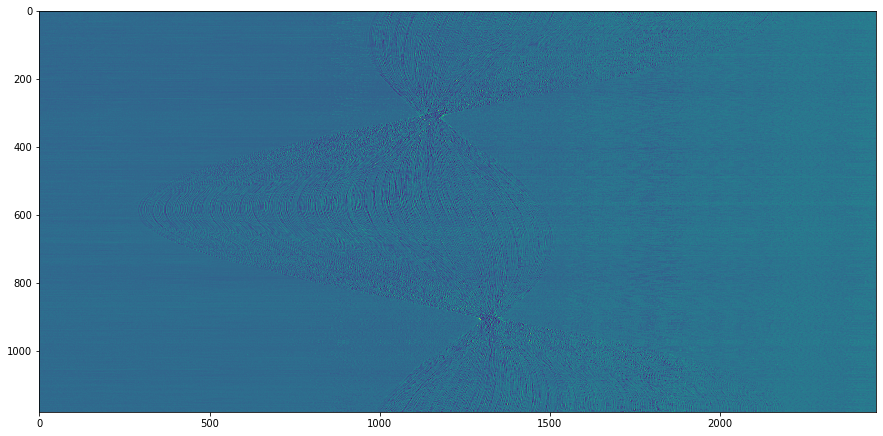

In [12]:
plt.figure(figsize=(15, 20))
plt.imshow(convert2uint8(tiffs[-1]))
# plt.imsave()

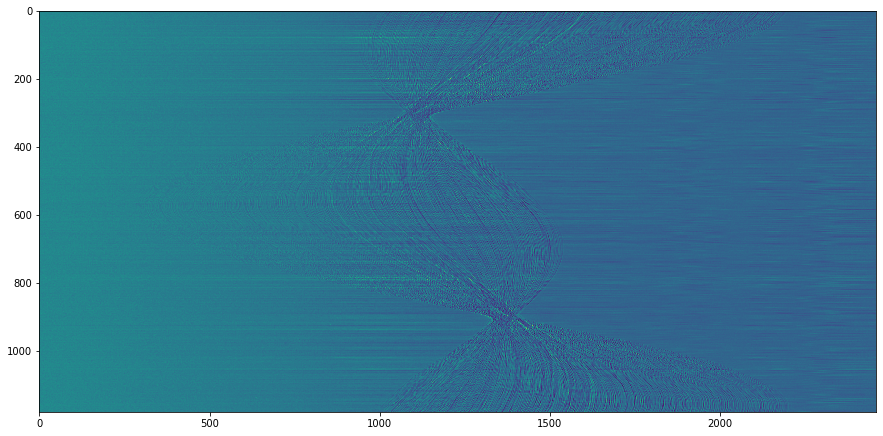

In [13]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[1])

## Take need axes

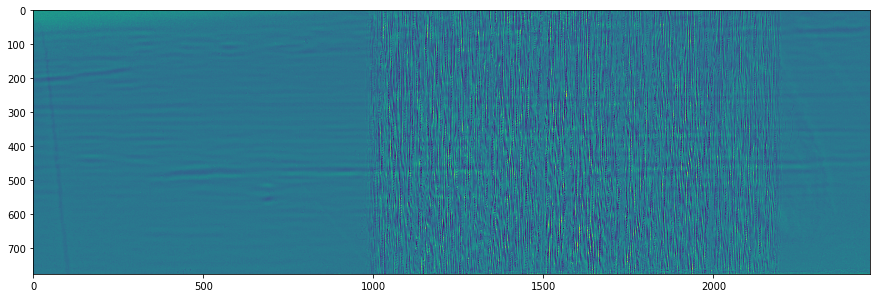

In [14]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,0, :])
# plt.imsave('left.png', tiffs[:,0, :])

In [15]:
np.where(angles.squeeze() * 180 / np.pi >= 180)[0][0]

590

In [16]:
(angles.squeeze() * 180 / np.pi)[590]

180.15549830220712

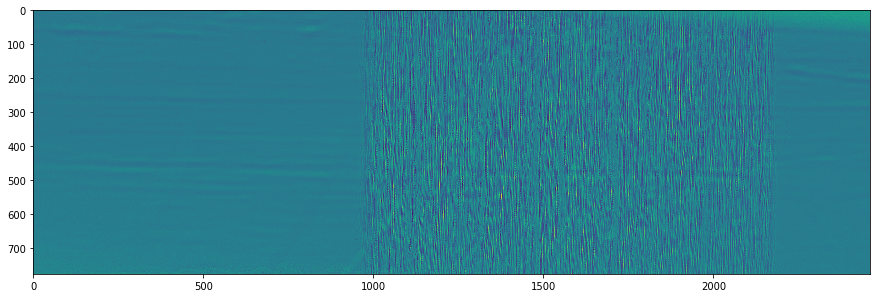

In [17]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,590, ::-1])
# plt.imsave('right.png',tiffs[:,376, ::-1])

Если сравнить как раз кажется виден этот нужный сдвиг!

In [18]:
# TBD:

def convert2uint8(img):
    return ((img - img.min()) / img.max() * 255).astype('uint8')

In [19]:
i = 5

In [20]:
left = convert2uint8(tiffs[:,0+i, :])
right = convert2uint8(tiffs[:,590+i, ::-1])

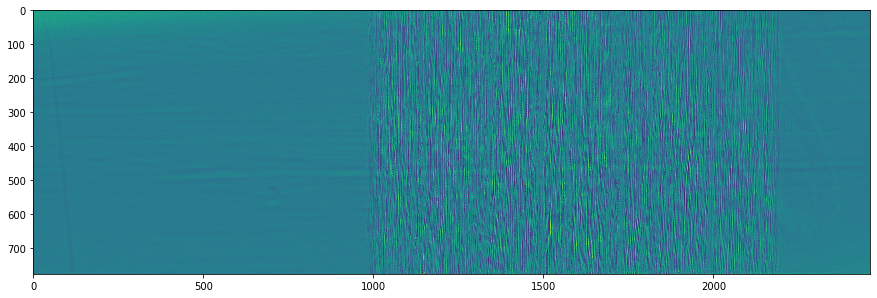

In [21]:
plt.figure(figsize=(15, 20))
plt.imshow(left)
# plt.imsave('left.png', left)

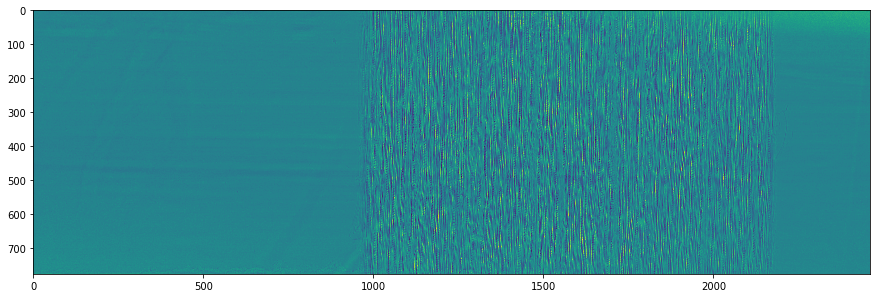

In [22]:
plt.figure(figsize=(15, 20))
plt.imshow(right)
# plt.imsave('right.png', right)

## Find minimal sums over availble shift axes (it works!)

In [23]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [24]:
def find_with_mse(left, right, shift = 15, use_pad=False, use_spline_minima=True, loss='l2', ignore_percent=0):
    best_id = 0
    temp_sum_arr = []
    for i in range(-shift, shift):
        if use_pad:
            if i < 0:
                left_temp = np.hstack([np.full((left.shape[0], abs(i)), left.mean()), left[:, :-abs(i)]])
            else:
                left_temp = np.hstack([left[:, abs(i):], np.full((left.shape[0], abs(i)), left.mean())])
        else:
            left_temp = left[:,i + shift:i - shift].copy()
        right_temp = right[:, shift:-shift].copy()
        if ignore_percent > 0:
            right_temp[:, int(right_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(right_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
            left_temp[:, int(left_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(left_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
        if loss == 'l2':
            temp_sum = (np.square(right_temp - left_temp)).mean()
        else:
            temp_sum = (np.abs(right_temp - left_temp)).mean()
        temp_sum_arr.append(temp_sum)
    if use_spline_minima:
        x_axis = np.arange(-shift, shift)
        f = InterpolatedUnivariateSpline(x_axis, np.array(temp_sum_arr), k=4)
        cr_pts = f.derivative().roots()
        cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
        cr_vals = f(cr_pts)
        min_index = np.argmin(cr_vals)
        max_index = np.argmax(cr_vals)
#         print(cr_pts, cr_vals)
        min_point = cr_pts[min_index]
    else:
        min_point = np.argmin(temp_sum_arr) - shift
    return min_point, np.array(temp_sum_arr)

## Sanity check

In [27]:
shift = 30
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
ids = []
for ax_id, i in enumerate(range(0, 20, 5)):
    ax = axs[ax_id]
    left = convert2uint8(tiffs[:,0+i, :])
    right = convert2uint8(tiffs[:,590+i, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    ids.append(best_id)
    ax.plot(np.arange(-shift, shift), temp_sum_arr)
    if ax_id == 0:
        ax.set_ylabel('mse')
    ax.axvline(x=3.5 * 2, color='k', linestyle='--')
    ax.set_xlabel('shift')

In [28]:
np.array(ids) / 2

array([9.4524314 , 9.4021984 , 9.27828866, 9.02612462])

In [30]:
converted_angles = angles.squeeze() * 180 / np.pi

## Run massive tests with a best fitted - no normalization

In [31]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [32]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [33]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 8.604054200104505 standart error: 0.14724397330249225


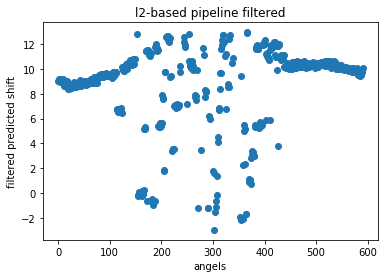

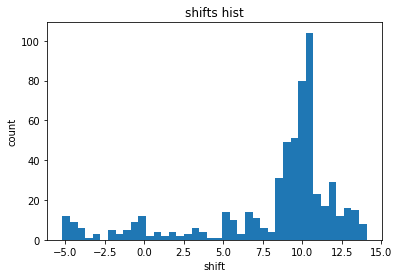

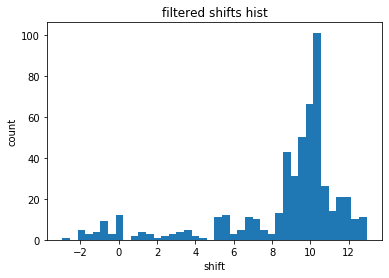

In [34]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Run massive tests with a best fitted - normalized

In [35]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = convert2uint8(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [36]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [37]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 8.963257250431752 standart error: 0.197940557323164


In [38]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Ignore center of the image

In [39]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.3)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [40]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [41]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 8.48007659520921 standart error: 0.22172225701868936


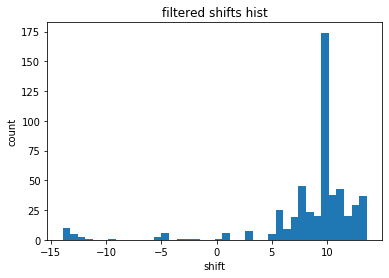

In [42]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Higher percent

In [43]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.5)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [44]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [45]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 7.91597663941472 standart error: 0.15798721376352323


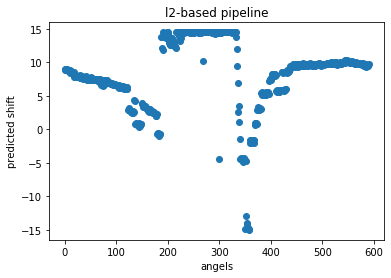

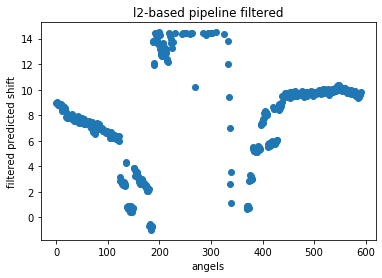

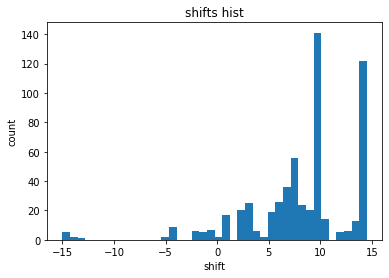

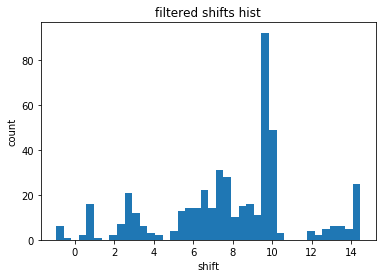

In [46]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Lower percent

In [47]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.1)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [48]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [49]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 6.112635997324347 standart error: 0.3023907311194533


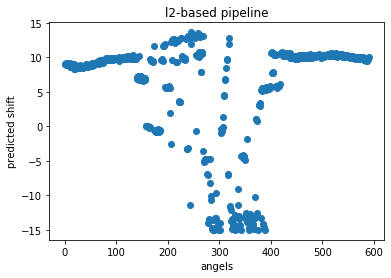

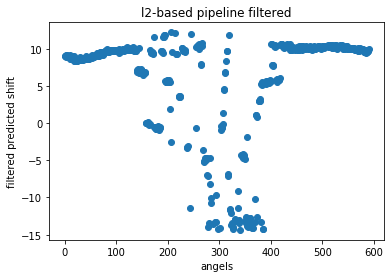

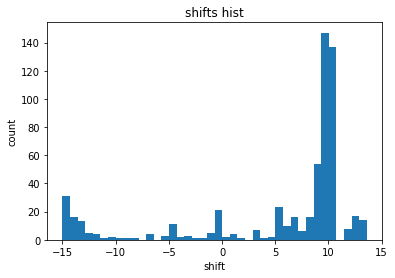

In [50]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Check with some recostructions

In [51]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[0, :, :], angles.squeeze(), ncols=3)
plt.show()

100%|██████████| 12/12 [25:50<00:00, 129.18s/it]


In [52]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[0, :, :], angles.squeeze(), ncols=3, from_x=1100, to_x=1500, from_y=1200, to_y=1500)
plt.show()

100%|██████████| 12/12 [24:53<00:00, 124.43s/it]


100%|██████████| 12/12 [38:45<00:00, 193.83s/it]


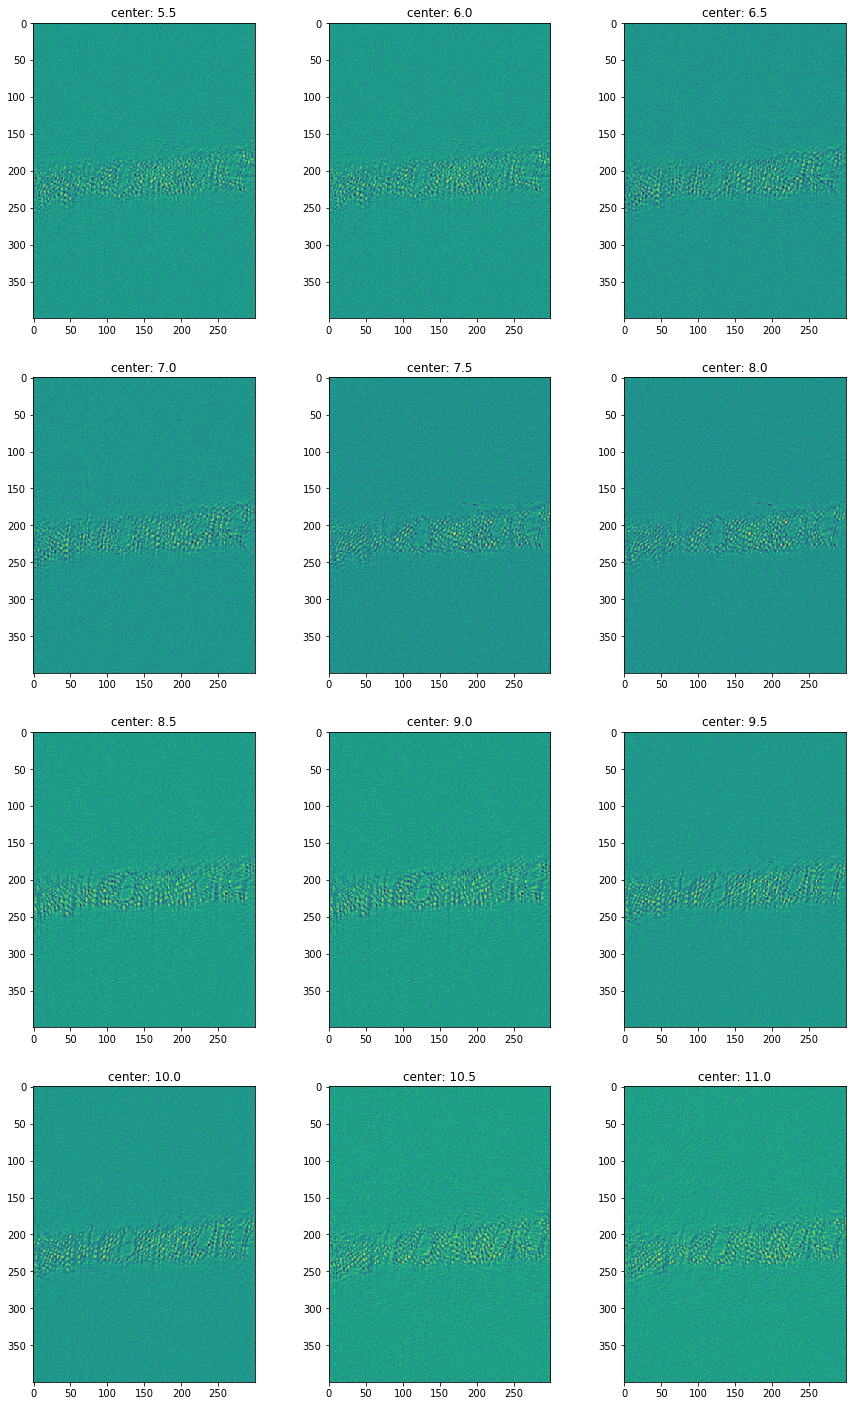

In [54]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[-1, :, :], angles.squeeze(), ncols=3, from_x=1100, to_x=1500, from_y=1200, to_y=1500)
plt.show()